In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

JAK_INHIBITORS = False

data_dir = "../data/11142025_IF_scan"
if_data_files = ["Cell.csv"]

columns = ["WellId", "CircTotalIntenCh2", "CircTotalIntenCh3"]

column_to_stain = dict(zip(range(1,13), ["pSTAT"]*6 + ["tSTAT"] * 6))
column_to_stain = dict(zip(range(1,13), ["tSTAT"]*12))
#column_to_stain = dict(zip(range(1,13), ["Old"]*3 + ["New"]*9))

row_to_t_pts = {
	#"A":0,
	"B":0,
	"C":0,
	"D":0,
	"E":0,
	"F":0,
	#"G":60,
	#"H":90
}	

column_to_patient = {
	#1:813,
	2:813,
	3:826,
	4:826,
	5:826,
	6:904,
	7:904,
	8:905,
	9:905,
	#10:905,
	#11:905,
	#12:905
}

row_to_replicate = {
	#"A":1,
	"B":1,
	"C":2,
	"D":1,
	"E":2,
	"F":1,
	#"G":2,
	#"H":1    
}

column_to_replicate = {
	#1:1,
	2:1,
	3:2,
	4:1,
	5:2,
	6:1,
	7:2,
	8:1,
	9:2,
	#10:1,
	#11:2,
	#2:3
}


In [2]:
dfs = []
for fname in if_data_files:
	full_fname = f"{data_dir}/{fname}"
	df = pd.read_csv(full_fname, usecols=columns)

	stat1_means = df.groupby("WellId")["CircTotalIntenCh2"].mean()
	stat1_sems = df.groupby("WellId")["CircTotalIntenCh2"].std()
	stat3_means = df.groupby("WellId")["CircTotalIntenCh3"].mean()
	stat3_sems = df.groupby("WellId")["CircTotalIntenCh3"].std()

	stat_df = pd.concat([stat1_means, stat1_sems, stat3_means, stat3_sems], axis=1)
	stat_df.columns = ["STAT1 Mean", "STAT1 SEM", "STAT3 Mean", "STAT3 SEM"]
	stat_df.index = [x.strip() for x in stat_df.index]
	# Assign various characteristics based on wells using the dictionaries above
	rows = [x.strip()[0] for x in stat_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_df.index.values]
	stat_df["STAT"] = [column_to_stain[x] for x in cols]
	stat_df["PatientId"] = [column_to_patient[x] for x in cols]
	stat_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	stat_df["Time"] = [row_to_t_pts[x] for x in rows]
	stat_df["Replicate"] = [column_to_replicate[x] for x in cols]
	stat_df["Date"] = data_dir.split("/")[-1]

 
	###############################################
	#### ADD IN SPECIAL OVERRIDES IF NECESSARY ####
	stat_df.loc["F01", "Time"] = 60
 
	display(stat_df)
	stat_df.to_csv(f"{data_dir.split('/')[-1]}.csv")
	dfs.append(stat_df)
 
patient_to_marker = {
	617:"s",
	626:"*",
	813:"v",
	826:"X",
	904:"P",
	905:"o"
}


,STAT1 Mean,STAT1 SEM,STAT3 Mean,STAT3 SEM,STAT,PatientId,IL-6 Concentration,Time,Replicate,Date
B02,9.825247e+06,4.413434e+06,5.688631e+06,2.538134e+06,tSTAT,813,10 ng/mL,0,1,11142025_IF_scan
B03,9.196750e+06,3.466116e+06,5.778663e+06,2.148707e+06,tSTAT,813,10 ng/mL,0,2,11142025_IF_scan
B04,5.467817e+06,2.765199e+06,4.873494e+06,2.175186e+06,tSTAT,826,10 ng/mL,0,1,11142025_IF_scan
B05,5.709720e+06,2.659739e+06,5.111398e+06,2.035352e+06,tSTAT,826,10 ng/mL,0,2,11142025_IF_scan
B06,3.921432e+06,2.084507e+06,4.545639e+06,1.558307e+06,tSTAT,904,10 ng/mL,0,1,11142025_IF_scan
B07,4.009544e+06,2.046678e+06,4.777266e+06,2.052185e+06,tSTAT,904,10 ng/mL,0,2,11142025_IF_scan
B08,7.223549e+06,3.749697e+06,5.441614e+06,2.549769e+06,tSTAT,905,10 ng/mL,0,1,11142025_IF_scan
B09,6.641811e+06,3.466331e+06,5.114102e+06,2.683059e+06,tSTAT,905,10 ng/mL,0,2,11142025_IF_scan
C02,1.056394e+07,4.911923e+06,6.002956e+06,2.887603e+06,tSTAT,813,10 ng/mL,0,1,11142025_IF_scan
C03,9.098642e+06,4.089721e+06,5.583991e+06,2.395425e+06,tSTAT,813,10 ng/mL,0,2,11142025_IF_scan


(2,)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

813 vs. 826: t-test independent samples with Bonferroni correction, P_val:2.626e-08 t=1.047e+01
826 vs. 904: t-test independent samples with Bonferroni correction, P_val:4.095e-02 t=3.055e+00
904 vs. 905: t-test independent samples with Bonferroni correction, P_val:1.352e-01 t=-2.495e+00
813 vs. 904: t-test independent samples with Bonferroni correction, P_val:1.752e-10 t=1.428e+01
826 vs. 905: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-2.434e-01
813 vs. 905: t-test independent samples with Bonferroni correction, P_val:7.616e-07 t=8.375e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

813 vs. 826: t-test independent s

Text(0.5, 79.16666666666664, 'Donor')

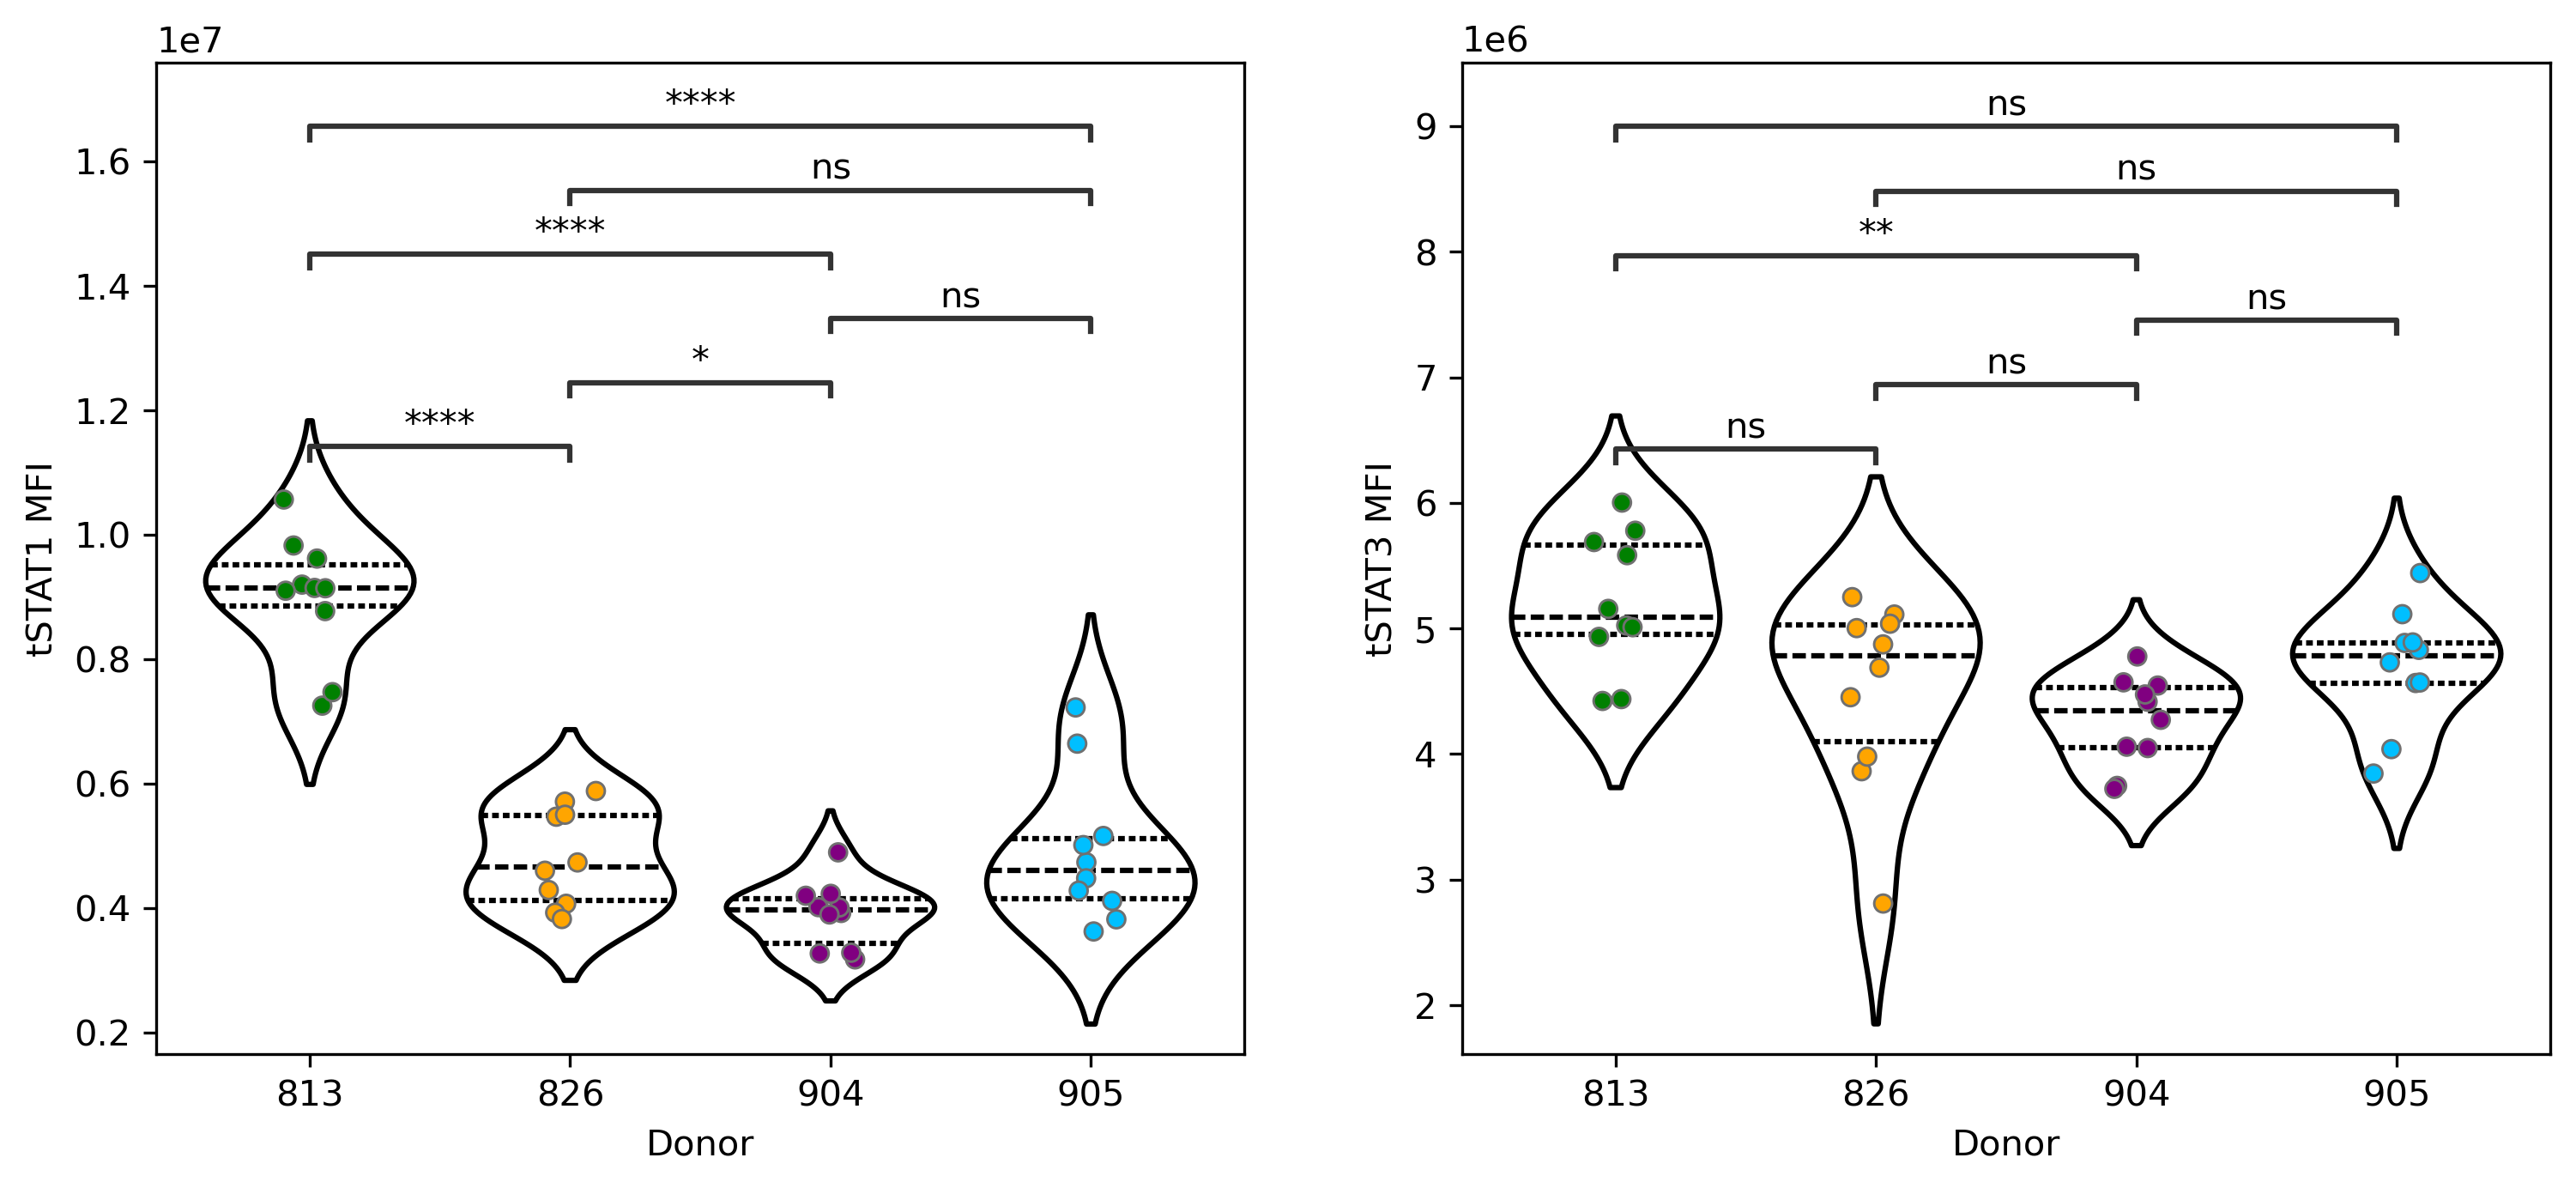

In [5]:
patient_to_marker = {
	617:"s",
	626:"*",
	813:"v",
	826:"x",
	904:"P",
	905:"o"
}


patient_to_color = {
	617: "r",
	626: "darkblue",
	813: "g",
	826: "orange",
	904: "purple",
	905: "deepskyblue"
}

df = dfs[0]
ms = 6 # markersize
fig1, axs = plt.subplots(1,2, figsize=(12,5), dpi=300)
print(axs.shape)
df["STAT1 SEM"] = [0] * len(df)
df["STAT3 SEM"] = [0] * len(df)

stat1_ax = axs[0]
stat3_ax = axs[1]
# Select tSTAT measurement
sns.stripplot(x="PatientId", y="STAT1 Mean", data=df, hue="PatientId", palette=patient_to_color, ax=axs[0], edgecolor="#707070", linewidth=0.7, legend=False)
sns.violinplot(x="PatientId", y="STAT1 Mean", data=df, hue="PatientId", palette=patient_to_color, ax=axs[0], edgecolor="#000000", fill=False, inner="quart", legend=False)
sns.stripplot(x="PatientId", y="STAT3 Mean", data=df, hue="PatientId", palette=patient_to_color, ax=axs[1], edgecolor="#707070", linewidth=0.7, legend=False)
sns.violinplot(x="PatientId", y="STAT3 Mean", data=df, hue="PatientId", palette=patient_to_color, ax=axs[1], edgecolor="#000000", fill=False, inner="quart", legend=False)


# ---- 1. Define all pairwise comparisons you want ----
patient_ids = df["PatientId"].unique()
pairs = [(a, b) for i, a in enumerate(patient_ids) for b in patient_ids[i+1:]]

# ---- 2. Create annotator ----
annotator = Annotator(
    stat1_ax,
    pairs,
    data=df,
    x="PatientId",
    y="STAT1 Mean"
)

# ---- 3. Configure the test you want ----
# You can change test='t-test_ind', 'Mann-Whitney', etc.
annotator.configure(
    test='t-test_ind',
    text_format='star',
    loc='inside',         # or 'outside'
    comparisons_correction='bonferroni'
)

# ---- 4. Run the test + add asterisks ----
annotator.apply_and_annotate()

# ---- 2. Create annotator ----
annotator = Annotator(
    stat3_ax,
    pairs,
    data=df,
    x="PatientId",
    y="STAT3 Mean"
)

# ---- 3. Configure the test you want ----
# You can change test='t-test_ind', 'Mann-Whitney', etc.
annotator.configure(
    test='t-test_ind',
    text_format='star',
    loc='inside',         # or 'outside'
    comparisons_correction='bonferroni'
)

# ---- 4. Run the test + add asterisks ----
annotator.apply_and_annotate()



stat1_ax.set_ylabel("tSTAT1 MFI")
#stat1_ax.margins(x=0.02)
#stat3_ax.margins(x=0.02);
stat1_ax.set_xlabel("Donor")
#stat1_ax.legend(title="Donor")
#stat1_ax.set_title("Fedratinib")
stat3_ax.set_ylabel("tSTAT3 MFI")
stat3_ax.set_xlabel("Donor")
#stat3_ax.legend(title="Donor")


(2,)


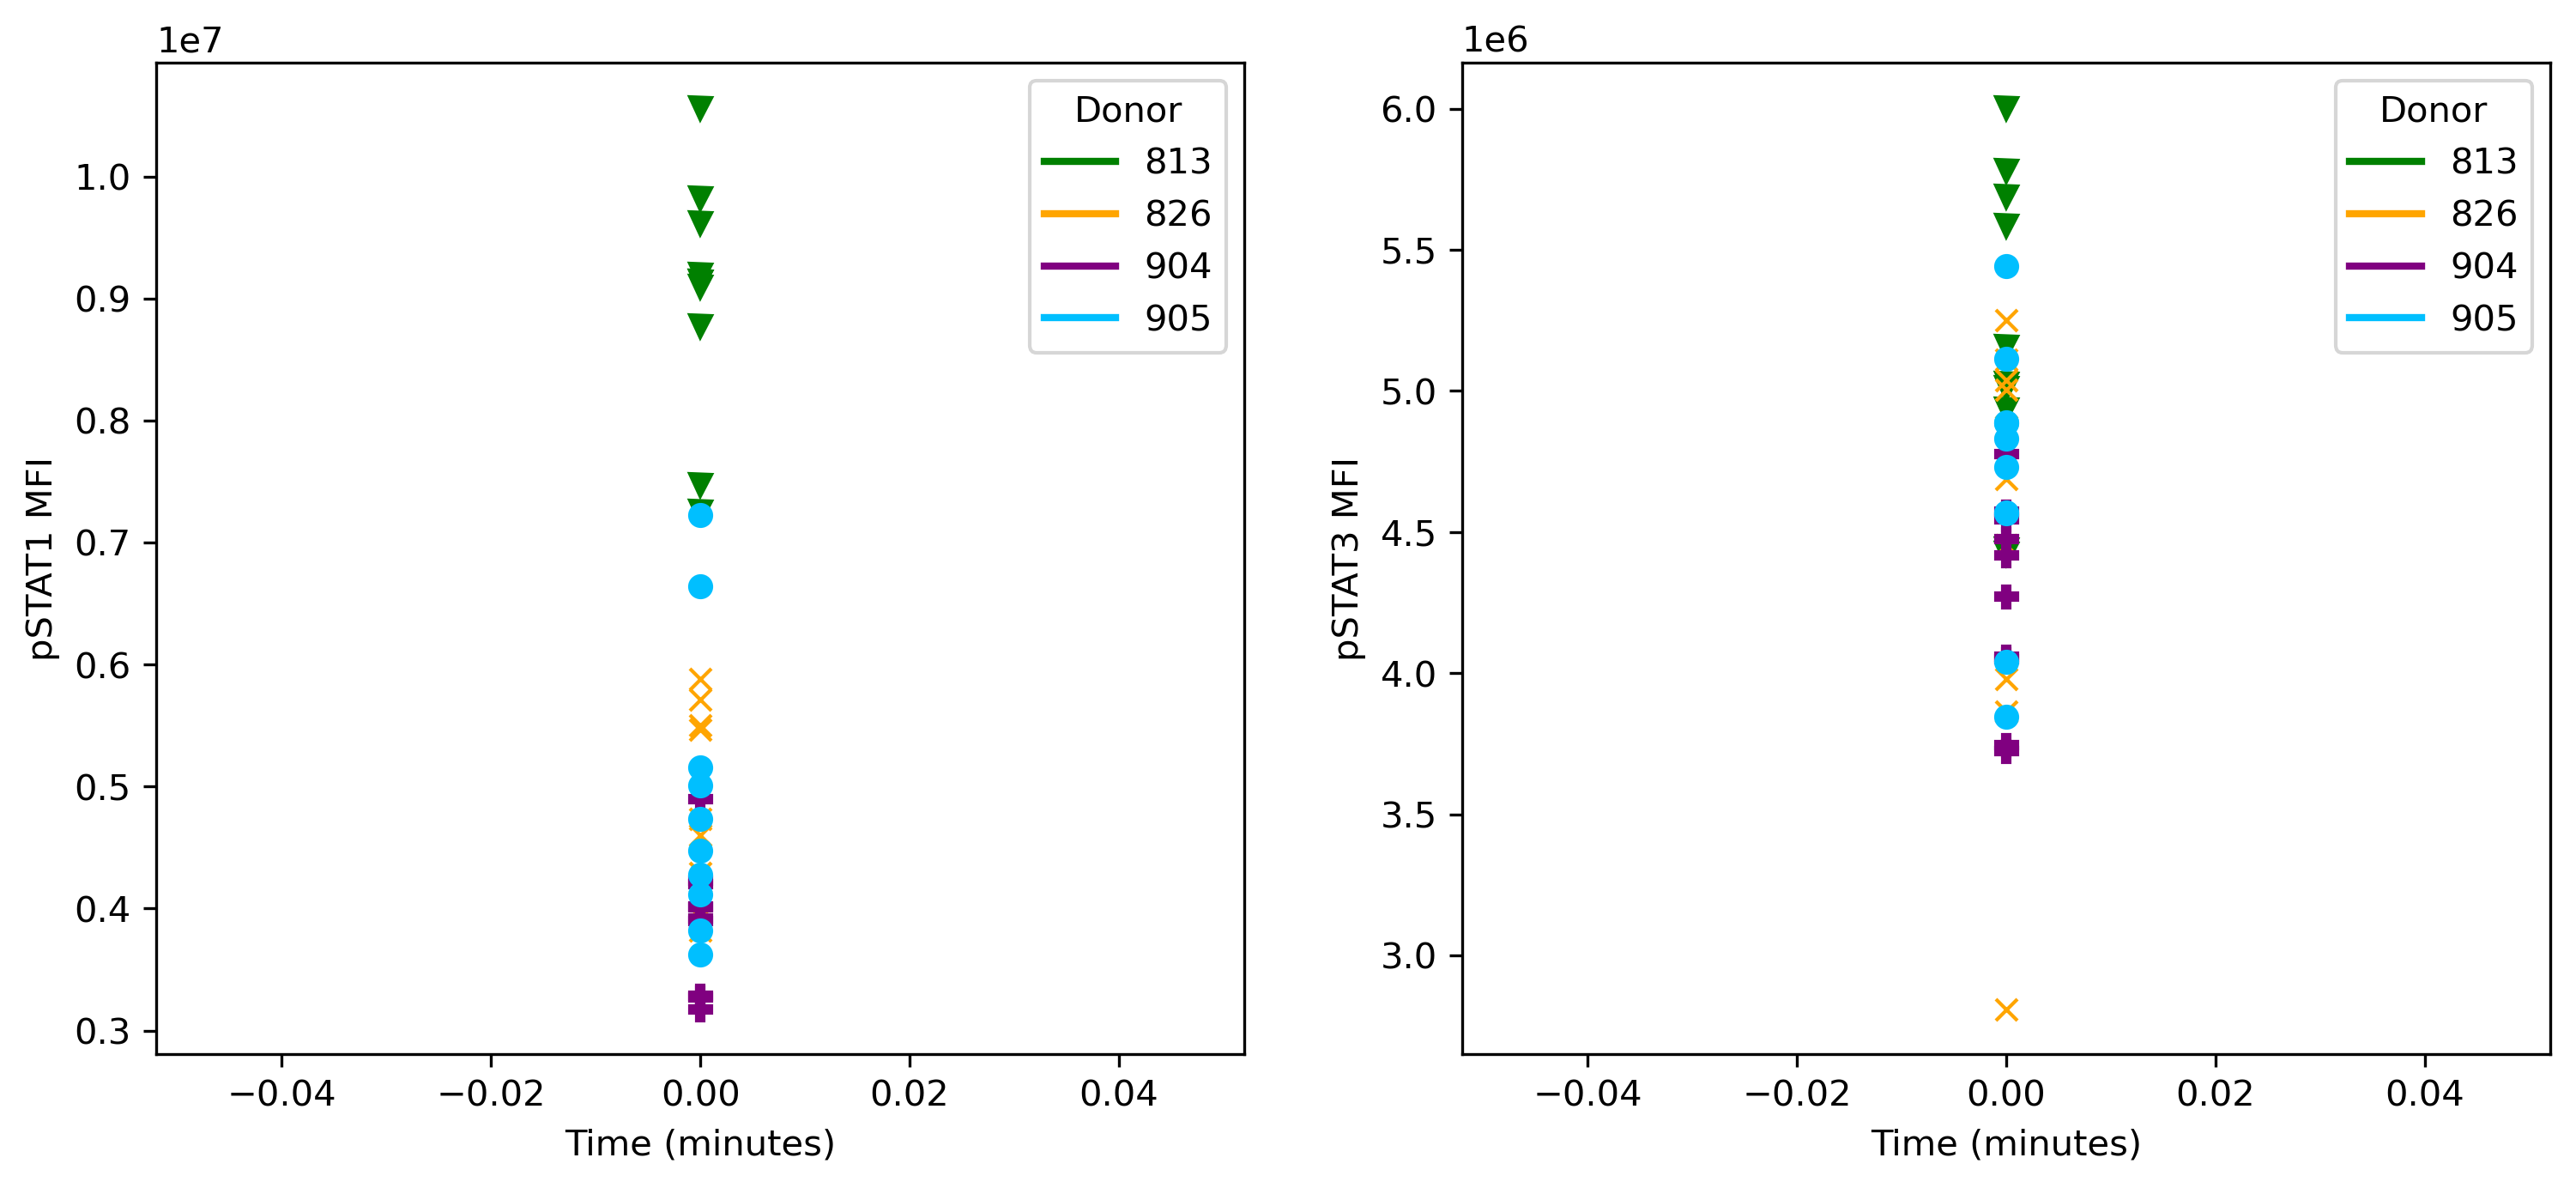

In [4]:
import random

def generate_random_colors(n):
	"""
	Generates a list of n random RGB color tuples.
	Each color is represented as a tuple (r, g, b) where r, g, and b are
	integers between 0 and 255 (inclusive).
	"""
	colors = []
	for _ in range(n):
		r = random.randint(0, 255)/255.0
		g = random.randint(0, 255)/255.0
		b = random.randint(0, 255)/255.0
		colors.append((r, g, b))
	return colors

patient_to_marker = {
	617:"s",
	626:"*",
	813:"v",
	826:"x",
	904:"P",
	905:"o"
}


patient_to_color = {
	617: "r",
	626: "darkblue",
	813: "g",
	826: "orange",
	904: "purple",
	905: "deepskyblue"
}

df = dfs[0]
ms = 6 # markersize
fig1, axs = plt.subplots(1,2, figsize=(12,5), dpi=300)
print(axs.shape)
df["STAT1 SEM"] = [0] * len(df)
df["STAT3 SEM"] = [0] * len(df)
# Select tSTAT measurement

for pat in df["PatientId"].unique():
	if pat == 8260:# or pat == 905:
		continue;
	# Plot tSTATs from first scan
	stat1_ax = axs[0]
	stat3_ax = axs[1]
 
	cur_df = df.loc[df["PatientId"] == pat]

	#stat1_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT1 Mean"].mean(),
	#				marker="none", color=patient_to_color[pat], 
	# 				lw=2, label=f"{pat}")#) Average")
	sns.lineplot(x="Time", y="STAT1 Mean", data=cur_df,	color=patient_to_color[pat], 
	 				lw=2, label=f"{pat}", ax=stat1_ax, errorbar=None)
	sns.lineplot(x="Time", y="STAT3 Mean", data=cur_df,	color=patient_to_color[pat], 
	 				lw=2, label=f"{pat}", ax=stat3_ax, errorbar=None)
 
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"]== rep)]
		#if 0 == 0:
		#	continue; 
		if select_df.empty:
			continue
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none",)
#	 				lw=0.75, label=f"{pat} - {rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none",) 
	 				#lw=0.75,  label=f"{pat} - {rep}", capsize=2)
	stat1_ax.set_ylabel("pSTAT1 MFI")
	stat1_ax.margins(x=0.02)
	stat3_ax.margins(x=0.02);
	stat1_ax.set_xlabel("Time (minutes)")
	stat1_ax.legend(title="Donor")
	#stat1_ax.set_title("Fedratinib")
	stat3_ax.set_ylabel("pSTAT3 MFI")
	stat3_ax.set_xlabel("Time (minutes)")
	stat3_ax.legend(title="Donor")
	#stat3_ax.set_title("Fedratinib")
	#stat1_ax.set_xlim(right=62)
	#stat3_ax.set_xlim(right=62)